In [1]:
# !pip install SimpleITK
# !pip install matplotlib
# !pip install scikit-learn
# !pip install segmentation_models

In [2]:
# import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

In [3]:
import SimpleITK as sitk
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# adc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/1ADC_ss'
adc_folder_path = 'BONBID2023_Train/1ADC_ss'
adc_files = [os.path.join(adc_folder_path, f) for f in os.listdir(adc_folder_path) if f.endswith('.mha')]
adc_files = sorted(adc_files)

In [5]:
# zadc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/2Z_ADC'
zadc_folder_path = 'BONBID2023_Train/2Z_ADC'
zadc_files = [os.path.join(zadc_folder_path, f) for f in os.listdir(zadc_folder_path) if f.endswith('.mha')]
zadc_files = sorted(zadc_files)

In [6]:
# label_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/3LABEL'
label_folder_path = 'BONBID2023_Train/3LABEL'
label_files = [os.path.join(label_folder_path, f) for f in os.listdir(label_folder_path) if f.endswith('.mha')]
label_files = sorted(label_files)

# **Read and display data**

Read and display ADC data

In [7]:
adc_data = []
adc_stik_data = []
for file in adc_files:
    image = sitk.ReadImage(file)
    adc_stik_data.append(image)
    array = sitk.GetArrayFromImage(image)
    adc_data.append(array)

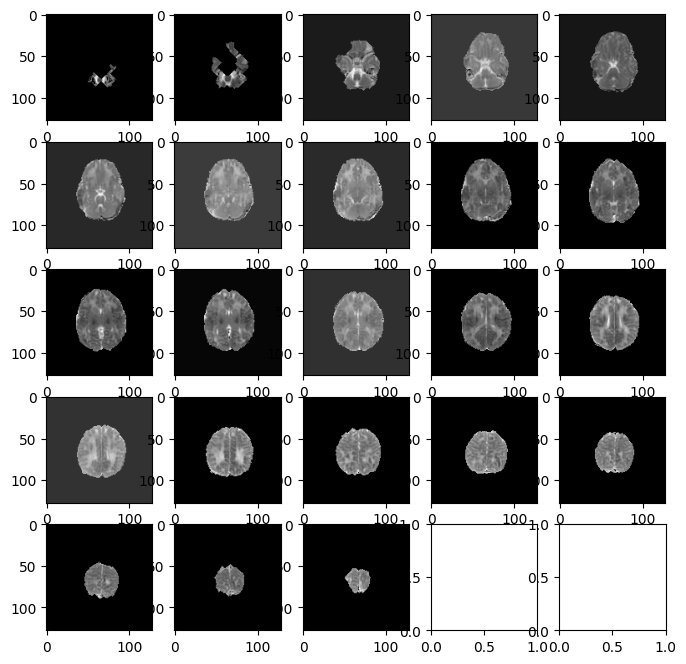

In [8]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < adc_data[0].shape[0]:
        ax.imshow(adc_data[0][i], cmap='gray')

Read and display Zadc data

In [9]:
zadc_data = []
for file in zadc_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    zadc_data.append(array)

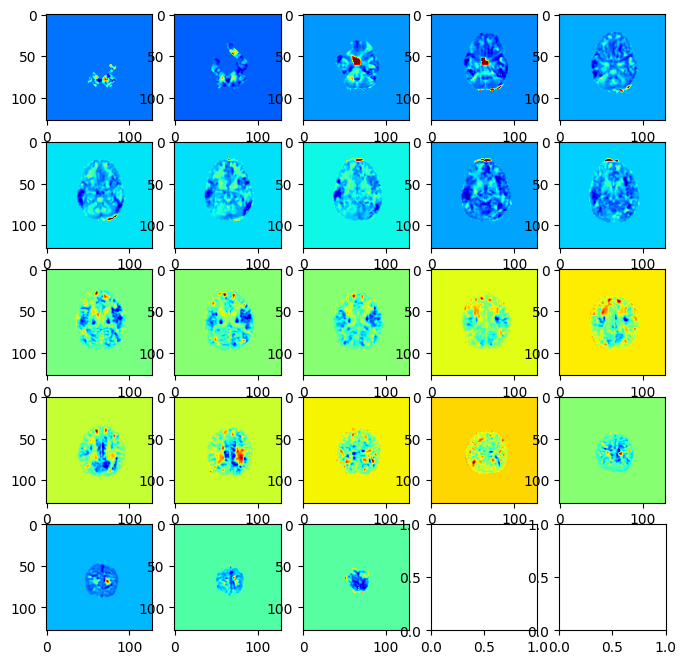

In [10]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < zadc_data[0].shape[0]:
        ax.imshow(zadc_data[0][i], cmap="jet")

Read and display label data

In [11]:
label_data = []
for file in label_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    label_data.append(array)

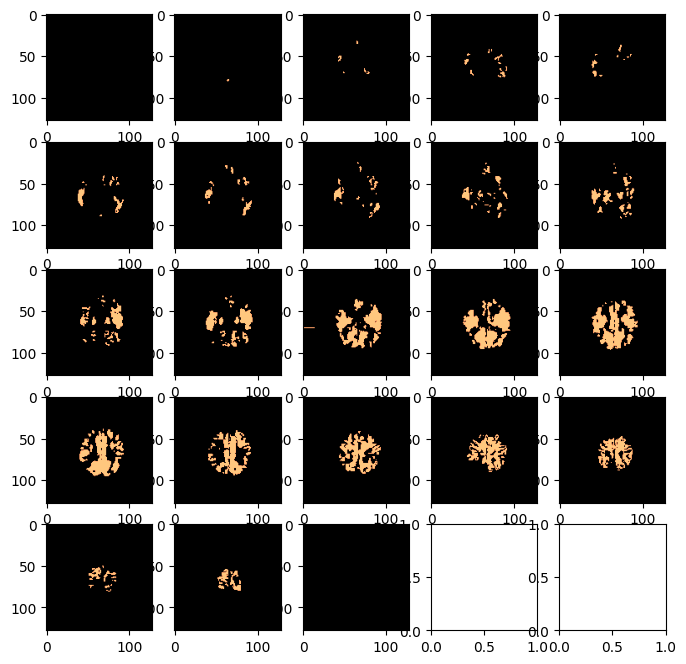

In [12]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < label_data[0].shape[0]:
        ax.imshow(label_data[0][i], cmap="copper")

# **Ready data for training**

In [13]:
# Flatten a list of data with n length and (m, 128, 128) shape of each array, so it becomes a list of n*m of arrays of shape (128, 128)

flattened_adc_data = [item for sublist in adc_data for item in sublist]
flattened_zadc_data = [item for sublist in zadc_data for item in sublist]
flattened_label_data = [item for sublist in label_data for item in sublist]


In [14]:
from sklearn.model_selection import train_test_split
flattened_zadc_data_train, flattened_zadc_data_test, flattened_label_data_train, flattened_label_data_test = train_test_split(flattened_zadc_data, flattened_label_data, test_size=0.1, random_state=42)


In [15]:
def slice_image(image):
    """
    Slices the given image into 64x64 patches.
    
    Args:
    image (numpy.ndarray): The image to be sliced, expected shape is (H, W).
    
    Returns:
    list: A list of 64x64 image patches.
    """
    patches = []
    h, w = image.shape
    
    if (h, w) == (256, 256):
        # Slicing 256x256 image into sixteen non-overlapping 64x64 patches
        for i in range(0, h, 64):
            for j in range(0, w, 64):
                patches.append(image[i:i+64, j:j+64])
    elif (h, w) == (160, 160):
        # Slicing 160x160 image with overlap to create 64x64 patches
        for i in range(0, h-64+1, 64):
            for j in range(0, w-64+1, 64):
                patches.append(image[i:i+64, j:j+64])
        # Adding overlapping patches
        patches.append(image[96:160, 96:160])
    elif (h, w) == (128, 128):
        # Slicing 128x128 image with overlap to create 64x64 patches
        for i in range(0, h-64+1, 64):
            for j in range(0, w-64+1, 64):
                patches.append(image[i:i+64, j:j+64])
    elif (h, w) == (64, 64):
        # Returning the image itself if it's already 64x64
        patches.append(image)
    else:
        raise ValueError("Unsupported image size. Expected (64, 64), (128, 128), (160, 160), or (256, 256).")
    
    return patches

def process_images_and_labels(images, labels):
    """
    Processes lists of images and labels, slicing each into 64x64 patches.
    
    Args:
    images (list): List of numpy.ndarray images.
    labels (list): List of numpy.ndarray labels corresponding to the images.
    
    Returns:
    tuple: Two lists containing the sliced images and corresponding labels.
    """
    all_image_patches = []
    all_label_patches = []
    
    for image, label in zip(images, labels):
        image_patches = slice_image(image)
        label_patches = slice_image(label)
        
        all_image_patches.extend(image_patches)
        all_label_patches.extend(label_patches)
    
    return all_image_patches, all_label_patches


In [16]:
flattened_cropped_zadc_data_list, flattened_cropped_label_data_list = process_images_and_labels(flattened_zadc_data_train, flattened_label_data_train)

flattened_test_cropped_zadc_data_list, flattened_test_cropped_label_data_list = process_images_and_labels(flattened_zadc_data_test, flattened_label_data_test)

In [17]:
len(flattened_cropped_zadc_data_list)

22944

In [18]:
len(flattened_test_cropped_zadc_data_list)

2828

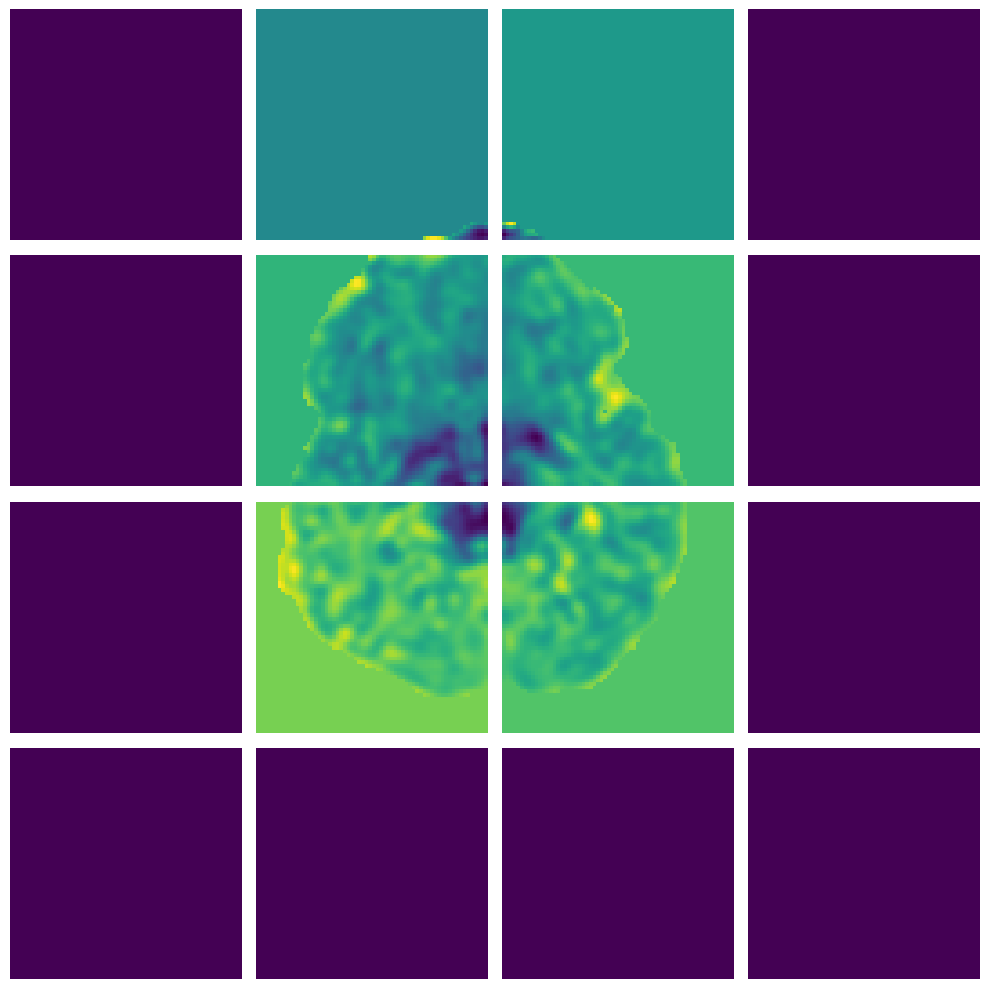

In [19]:
def display_patches(original_image, patches):
    """
    Display the 64x64 patches in a grid to verify their placement.
    
    Args:
    original_image (numpy.ndarray): The original image before slicing.
    patches (list): A list of 64x64 image patches.
    """
    h, w = original_image.shape
    fig, axs = plt.subplots(h // 64, w // 64, figsize=(10, 10))
    
    patch_index = 0
    for i in range(h // 64):
        for j in range(w // 64):
            axs[i, j].imshow(patches[patch_index])
            axs[i, j].axis('off')
            patch_index += 1

    plt.tight_layout()
    plt.show()

# Display patches for the first image
original_image = flattened_zadc_data_train[3]
patches = slice_image(original_image)
display_patches(original_image, patches)

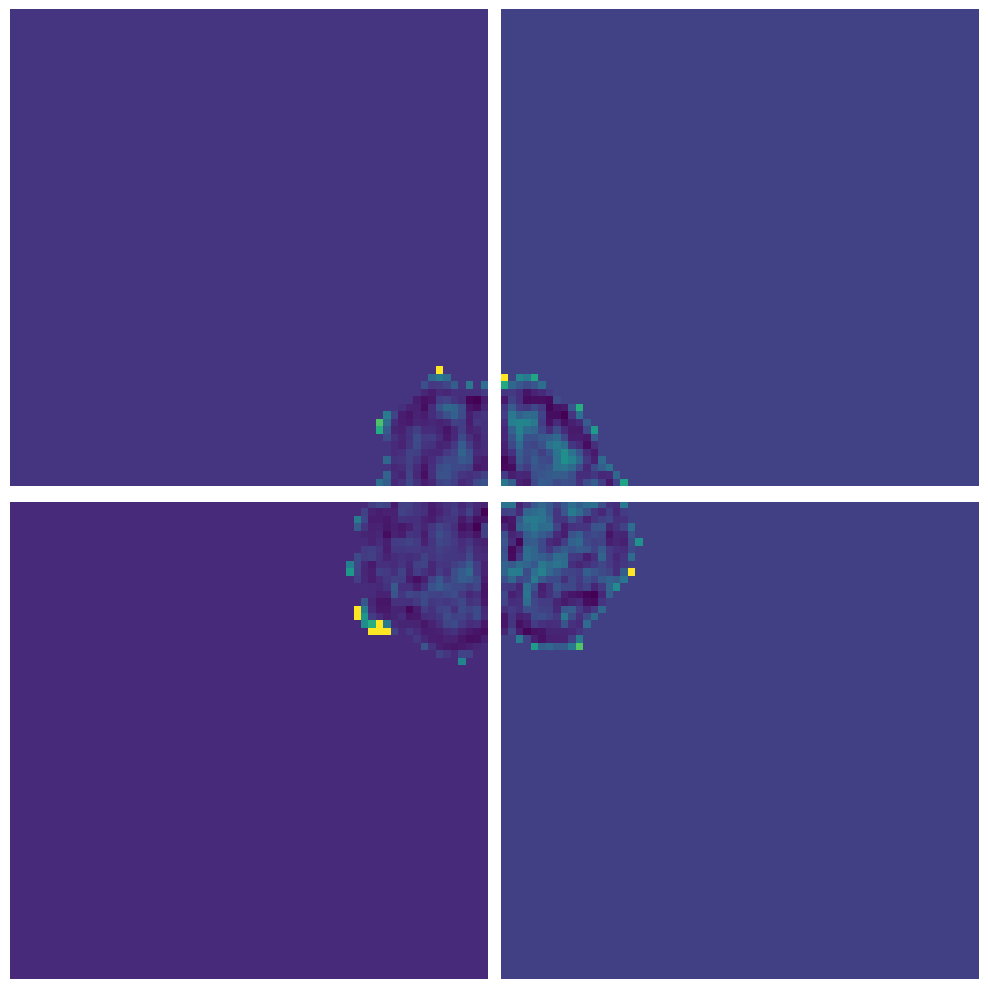

In [20]:
# Display patches for the first image
original_image = flattened_zadc_data_test[3]
patches = slice_image(original_image)
display_patches(original_image, patches)

In [21]:
# Train data
# Convert the list of arrays to a single NumPy array
flattened_cropped_zadc_data = np.array(flattened_cropped_zadc_data_list)

# Reshape the array to have shape (num_samples, 128, 128, 1)
flattened_cropped_zadc_data = flattened_cropped_zadc_data.reshape((len(flattened_cropped_zadc_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_cropped_zadc_data.shape)

# If you also have label data in the same format

flattened_cropped_label_data = np.array(flattened_cropped_label_data_list)
flattened_cropped_label_data = flattened_cropped_label_data.reshape((len(flattened_cropped_label_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_cropped_label_data.shape)

(22944, 64, 64, 1)
(22944, 64, 64, 1)


In [22]:
#Test Data
# Convert the list of arrays to a single NumPy array
flattened_test_cropped_zadc_data = np.array(flattened_test_cropped_zadc_data_list)

# Reshape the array to have shape (num_samples, 128, 128, 1)
flattened_test_cropped_zadc_data = flattened_test_cropped_zadc_data.reshape((len(flattened_test_cropped_zadc_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_test_cropped_zadc_data.shape)

# If you also have label data in the same format

flattened_test_cropped_label_data = np.array(flattened_test_cropped_label_data_list)
flattened_test_cropped_label_data = flattened_test_cropped_label_data.reshape((len(flattened_test_cropped_label_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_test_cropped_label_data.shape)

(2828, 64, 64, 1)
(2828, 64, 64, 1)


# **U Net**

In [23]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
# Segmentation Models: using `keras` framework.

2024-07-26 17:21:47.190827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 17:21:47.462779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 17:21:47.569658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 17:21:47.594509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 17:21:47.794045: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `tf.keras` framework.


# **Model Save**

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt
import os

# Define paths
checkpoint_dir = '/ResNet18'
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}.keras')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')], key=os.path.getctime, default=None)
log_filepath = 'training_log_ResNet.csv'

# Create the CSVLogger
csv_logger = CSVLogger(log_filepath, append=True)

# ModelCheckpoint callback to save the model
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=False,
    save_freq='epoch'
)

# **Resnet18**

In [25]:

import segmentation_models as sm
from sklearn.model_selection import train_test_split

BACKBONE = 'resnet18'

# load your data
x_train, x_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# define model
model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(64, 64, 1))
model.compile(
    'Adam',
    loss=sm.losses.DiceLoss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore],
)

# Load model from the last checkpoint if it exists
if latest_checkpoint is not None:
    model = load_model(latest_checkpoint)
    print(f"Loaded model from {latest_checkpoint}")

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=1000,
   validation_data=(x_val, y_val),
   callbacks=[model_checkpoint_callback, csv_logger]
)

I0000 00:00:1722010911.014252   85605 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722010911.245354   85605 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722010911.245434   85605 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722010911.250355   85605 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722010911.250561   85605 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/500


I0000 00:00:1722010921.333740   85981 service.cc:146] XLA service 0x7f85b4003930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722010921.334001   85981 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-07-26 17:22:01.617263: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-26 17:22:02.803543: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1722010940.929916   85981 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


574/574 ━━━━━━━━━━━━━━━━━━━━ 84s 99ms/step - f1-score: 0.3804 - iou_score: 0.2864 - loss: 0.6196 - val_f1-score: 0.5757 - val_iou_score: 0.4611 - val_loss: 0.4254
Epoch 2/500
574/574 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - f1-score: 0.6697 - iou_score: 0.5445 - loss: 0.3303 - val_f1-score: 0.6939 - val_iou_score: 0.5852 - val_loss: 0.3069
Epoch 3/500
574/574 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - f1-score: 0.6891 - iou_score: 0.5614 - loss: 0.3109 - val_f1-score: 0.7004 - val_iou_score: 0.5836 - val_loss: 0.3002
Epoch 4/500
574/574 ━━━━━━━━━━━━━━━━━━━━ 34s 60ms/step - f1-score: 0.6946 - iou_score: 0.5723 - loss: 0.3054 - val_f1-score: 0.5297 - val_iou_score: 0.4091 - val_loss: 0.4707
Epoch 5/500
574/574 ━━━━━━━━━━━━━━━━━━━━ 116s 202ms/step - f1-score: 0.7101 - iou_score: 0.5850 - loss: 0.2899 - val_f1-score: 0.6352 - val_iou_score: 0.5236 - val_loss: 0.3658
Epoch 6/500
574/574 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - f1-score: 0.6655 - iou_score: 0.5483 - loss: 0.3345 - val_f1-score: 0.6759 - v

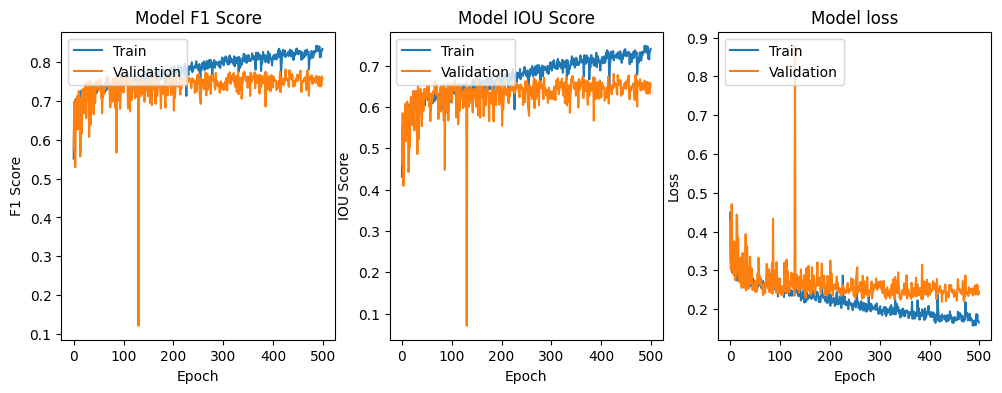

In [31]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


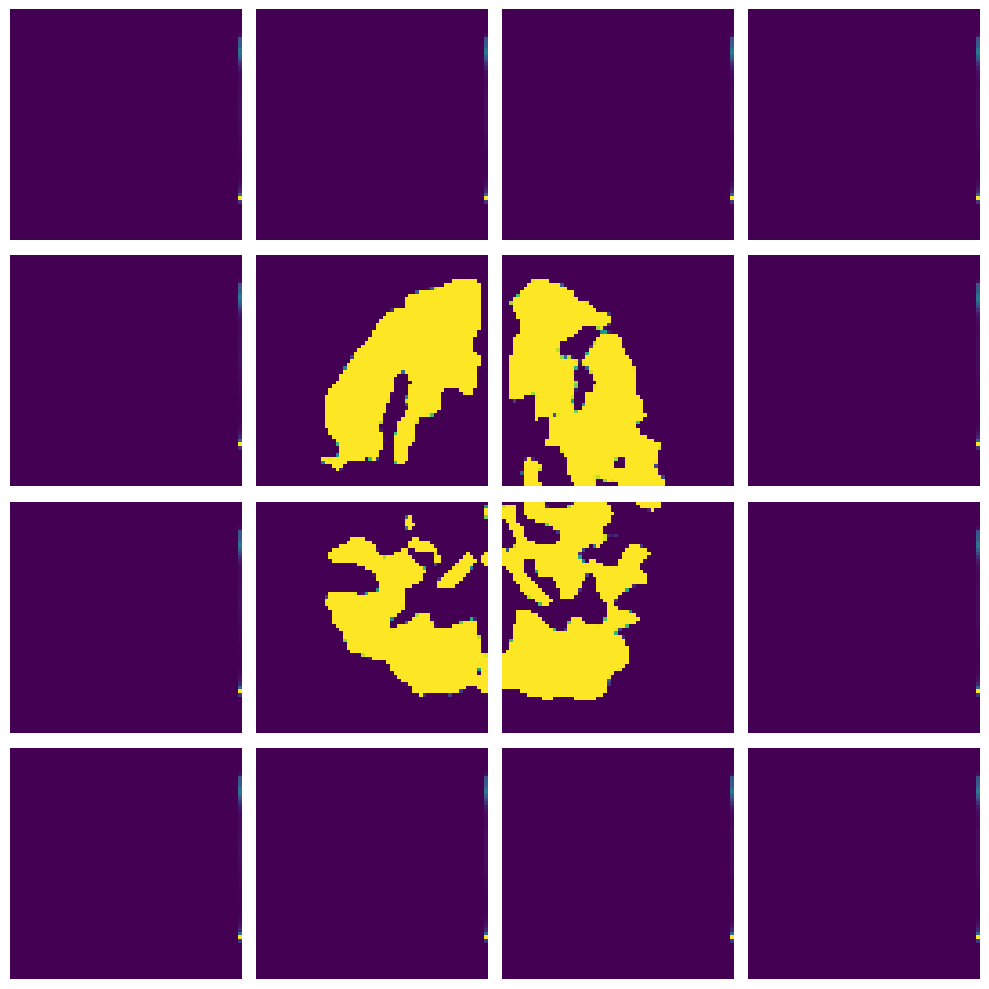

In [32]:
original_image = flattened_zadc_data_test[27]  #use test
patches = slice_image(original_image)

patches_data = np.array(patches)

# Reshape the array to have shape (num_samples, 128, 128, 1)
patches_data = patches_data.reshape((len(patches), 64, 64, 1))

predictions = model.predict(patches_data)
display_patches(original_image, predictions)


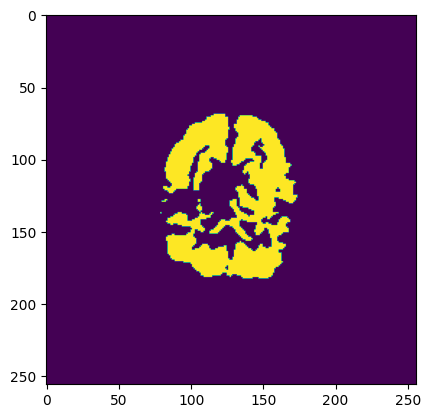

In [33]:
plt.imshow(flattened_label_data_test[27])

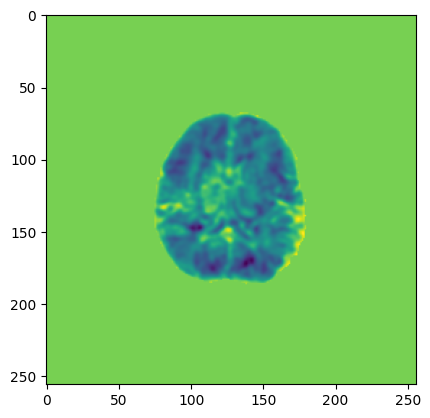

In [34]:
plt.imshow(flattened_zadc_data_test[27])

In [35]:
print(len(flattened_label_data_test))

321


In [36]:
# Evaluate the model
evaluation = model.evaluate(flattened_test_cropped_zadc_data, flattened_test_cropped_label_data, batch_size=32)

# Print the results
print("Evaluation results on test data:")
print(f"Loss: {evaluation[0]}")
print(f"IOU Score: {evaluation[1]}")
print(f"F1 Score: {evaluation[2]}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - f1-score: 0.6583 - iou_score: 0.5658 - loss: 0.3418
Evaluation results on test data:
Loss: 0.3128024935722351
IOU Score: 0.5936071872711182
F1 Score: 0.6893941164016724


In [ ]:
# images = x_val[200:203]
# labels = y_val[200:203]
# # Get model predictions on a few samples
# predictions = model.predict(images)

# # Visualize the predictions
# def visualize_predictions(images, labels, predictions, num_samples=3):
#     plt.figure(figsize=(12, 6))
#     for i in range(num_samples):
#         plt.subplot(3, num_samples, i + 1)
#         plt.imshow(images[i].reshape(64, 64), cmap='gray')
#         plt.title('Image')
#         plt.axis('off')

#         plt.subplot(3, num_samples, i + 1 + num_samples)
#         plt.imshow(labels[i].reshape(64, 64), cmap='gray')
#         plt.title('Label')
#         plt.axis('off')

#         plt.subplot(3, num_samples, i + 1 + 2*num_samples)
#         plt.imshow(predictions[i].reshape(64, 64), cmap='gray')
#         plt.title('Prediction')
#         plt.axis('off')
#     plt.show()

# visualize_predictions(images, labels, predictions)
